In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *

In [2]:
dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
vtk_file_reader = pv.POpenFOAMReader(dir)
vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
vtk_file_reader.cell_to_point_creation = False
vtk_file_reader.enable_all_patch_arrays()
vtk_mesh = vtk_file_reader.read()[0]

In [ ]:
from src.gauss_green import *
mesh = vfm_mesh_geometry(vtk_mesh,  dtype=torch.float64)
print(MeshQuality.report_quality_metrics(mesh))

Calculating face centers and areas for 37020 faces
Corrected 0 misaligned face area vectors
Mesh Geometry:
- n_cells 9200
- n_points 18840
- points torch.Size([18840, 3])
- cell_centres torch.Size([9200, 3])
- cell_faces 9200
- faces 37020
- internal_faces 18180
{'max_non_orthogonality': 43.433995038442895, 'avg_non_orthogonality': 4.755765077554514, 'max_skewness': 0.19769376516342163, 'avg_skewness': 0.005930359475314617}


In [4]:
print('less than 45deg', len(torch.where(mesh.non_orthogonality_angle[mesh.internal_faces] <45)[0]))
print('more than 45deg', len(torch.where(mesh.non_orthogonality_angle[mesh.internal_faces] >45)[0]))

less than 45deg 18180
more than 45deg 0


In [5]:
def check_vector_alignment(vectors_a, vectors_b):
    aligned = []
    for a, b in zip(vectors_a, vectors_b):
        a = np.array(a)
        b = np.array(b)
        dot = np.dot(a, b)
        aligned.append(dot > 0)
    return aligned

In [6]:
match_list = check_vector_alignment(mesh.face_normal_unit_vectors, 
                       mesh.cell_center_unit_vectors
                       )
match_list[:5]

[True, True, True, True, True]

In [7]:
misaligned_indices = np.where(~np.array(match_list))[0]
misaligned_indices[:5]

array([], dtype=int64)

In [8]:
dummy_face_normal_unit_vectors = mesh.face_normal_unit_vectors.clone()
dummy_face_normal_unit_vectors[misaligned_indices] *= -1
print(mesh.face_normal_unit_vectors[misaligned_indices][:5])
print(dummy_face_normal_unit_vectors[misaligned_indices][:5])

tensor([], size=(0, 3), dtype=torch.float64)
tensor([], size=(0, 3), dtype=torch.float64)


In [9]:
new_match_list = check_vector_alignment(dummy_face_normal_unit_vectors, 
                       mesh.cell_center_unit_vectors
                       )
new_match_list[:5]

[True, True, True, True, True]

In [10]:
new_misaligned_indices = np.where(~np.array(new_match_list))[0]
new_misaligned_indices[:5]

array([], dtype=int64)

**get order matching up between our method and OpenFoam**

In [11]:
meshOfpp = Ofpp.FoamMesh(r'C:\Users\Noahc\Downloads\c5_test')

In [12]:
Ofpp_sorted_faces = np.array([np.sort(face) for face in meshOfpp.faces])
def reorder_B_to_match_A(A, B):
    # Build a mapping from tuple(row) in B to its index
    row_to_index = {tuple(np.sort(row)): i for i, row in enumerate(B)}

    # Use this mapping to reorder B
    indices = [row_to_index[tuple(row)] for row in A]

    # Reorder B accordingly
    return indices

# Example usage
indices_reorder = reorder_B_to_match_A(Ofpp_sorted_faces, mesh.faces)

In [13]:
Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\Sf')[0,:10][0]

0.05709183

In [14]:
torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\Sf'),dtype=torch.float64)[0,:10][0].item()

0.05709183

In [15]:
Sf_gt = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\Sf'),dtype=mesh.dtype)

sf_field = torch.zeros((mesh.n_cells, 3), dtype=mesh.dtype)
sf_gt_field = torch.zeros((mesh.n_cells, 3), dtype=mesh.dtype)

sf_gt_field.index_add_(0, torch.tensor(meshOfpp.owner)[:18180], Sf_gt)
sf_gt_field.index_add_(0, torch.tensor(meshOfpp.neighbour)[:18180], -Sf_gt) 

sf_field.index_add_(0, mesh.face_owners[mesh.internal_faces], mesh.face_areas[mesh.internal_faces,:])
sf_field.index_add_(0, mesh.face_neighbors[mesh.internal_faces], -mesh.face_areas[mesh.internal_faces,:]) 
       

tensor([[0.0533, 0.0577, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.2121, 0.0000]], dtype=torch.float64)

In [16]:
# Extract columns for x, y, z
x, y, z = mesh.cell_centers[:, 0], mesh.cell_centers[:, 1], mesh.cell_centers[:, 2]

# Create boolean mask
mask = (
    (x >= -5) & (x <= 5) &
    (y >= -5) & (y <= 5) &
    (z >= -0.5) & (z <= 0.5)
)

# Get indices where the condition is True
indices = torch.nonzero(mask, as_tuple=False).squeeze()
max_difs = torch.argmax((sf_gt_field-sf_field)[indices], dim=0)

torch.argmin(mesh.cell_centers[:,0])
torch.where(mesh.cell_centers[:,0] <= -19.37)

(tensor([3100, 3130, 3160, 7700, 7701, 7702]),)

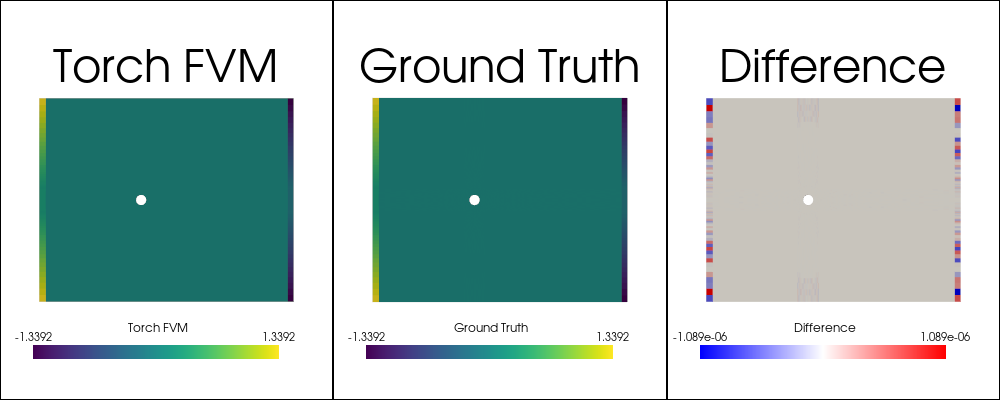

In [75]:
plot_comparison(vtk_mesh, None, f'Sf Difference',
                    prediction=sf_field.numpy(),
                    ground_truth = sf_gt_field.numpy(),
                    i=0, interactive = True, 
                    point_label=False,
                    #clims3=[-0.0000001, 0.0000001]
                    )

In [18]:
len(mesh.internal_faces)

18180

This looks more correct. **Main takeaway**: 
- CCW order of points.
- correction of normal direction

In [19]:
owner_0 = torch.where(mesh.face_owners[mesh.internal_faces] == 5000)[0]
neighbour_0 = torch.where(mesh.face_neighbors[mesh.internal_faces] == 5000)[0]
print('owner', owner_0)
print('neighbour', neighbour_0)
print(mesh.face_areas[owner_0])
print(mesh.face_areas[neighbour_0])

owner tensor([9950, 9951])
neighbour tensor([ 820, 9931])
tensor([[0.0000, 0.0000, 0.0513],
        [0.2629, 0.0010, 0.0000]], dtype=torch.float64)
tensor([[0.0052, 0.2146, 0.0000],
        [0.2555, 0.0010, 0.0000]], dtype=torch.float64)


For OpenFoam

In [20]:
owner_1 = torch.where(mesh.face_owners[indices_reorder][:18180] == 5000)[0]
neighbour_1 = torch.where(mesh.face_neighbors[indices_reorder][:18180] == 5000)[0]
print('owner', owner_1)
print('neighbour', neighbour_1)
print(Sf_gt[owner_1])
print(Sf_gt[neighbour_1])

owner tensor([9950, 9951])
neighbour tensor([ 822, 9932])
tensor([[ 1.7047e-04, -1.9255e-01, -1.6941e-21],
        [ 2.3587e-01, -5.5419e-03,  0.0000e+00]], dtype=torch.float64)
tensor([[ 0.0000e+00, -1.9251e-01,  0.0000e+00],
        [ 2.3604e-01, -5.5817e-03, -5.4210e-20]], dtype=torch.float64)


Ensure points match

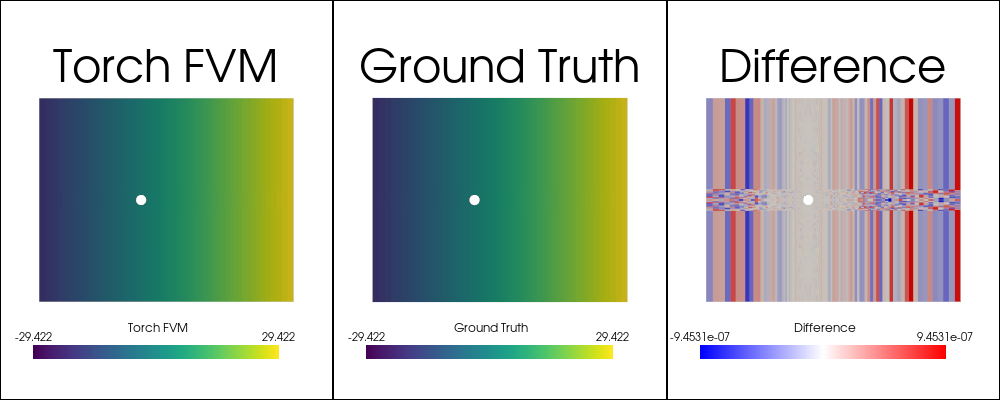

In [21]:
meshOfpp.read_cell_centres(r'C:\Users\Noahc\Downloads\c5_new_30\30\C')
plot_comparison(vtk_mesh, None, f'Sf Difference',
                    prediction=mesh.cell_centers.numpy(),
                    ground_truth = meshOfpp.cell_centres,
                    i=0, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

check vertices match in order

In [22]:
point_dif = mesh.vertices.numpy() - meshOfpp.points
print(point_dif.max())
print(point_dif.min()) 
print(point_dif.mean()) 

9.533837896924524e-07
-9.533837896924524e-07
-1.2070628636273753e-09


check area magnitudes match

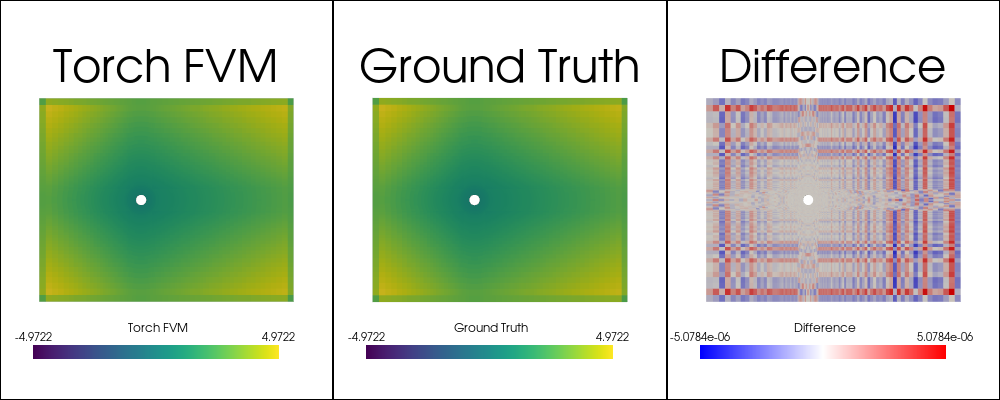

In [23]:
area = torch.norm(mesh.face_areas[mesh.internal_faces,:], dim=1)

# v1
area_gt = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\magSf'),dtype=mesh.dtype)
# v2
#area_gt = torch.norm(Sf_gt, dim=1) 

area_gt_field = torch.zeros((mesh.n_cells, 1),  dtype=mesh.dtype)
area_gt_field.index_add_(0, mesh.face_owners[indices_reorder][:18180],      area_gt)
area_gt_field.index_add_(0, mesh.face_neighbors[indices_reorder][:18180],  +area_gt) 

area_field = torch.zeros((mesh.n_cells, 1),     dtype=mesh.dtype)
area_field.index_add_(0, mesh.face_owners[mesh.internal_faces],     area)
area_field.index_add_(0, mesh.face_neighbors[mesh.internal_faces], +area) 

plot_comparison(vtk_mesh, None, f'Sum Area Difference',
                    prediction=area_field.numpy(),
                    ground_truth = area_gt_field.numpy(),
                    i=0, interactive = True, 
                    point_label=False,
                    #clims3=[-0.000001, 0.000001]
                    )

Looks like our area sum is now correct. But the vector direction must be off.

In [24]:
face_vertices_of = torch.tensor(meshOfpp.points[meshOfpp.faces[0]])
print(face_vertices_of)
v0 = face_vertices_of[0]
for j in range(1, 3):
    v1 = face_vertices_of[j]
    v2 = face_vertices_of[j + 1]
    # Cross product for triangle area
    triangle_area  = 0.5 * torch.linalg.cross(v1 - v0, v2 - v0)
    print(triangle_area.numpy())

tensor([[ 0.7560,  0.7560, -0.5000],
        [ 0.6944,  0.8131, -0.5000],
        [ 0.6944,  0.8131,  0.5000],
        [ 0.7560,  0.7560,  0.5000]], dtype=torch.float64)
[0.02854591 0.03078678 0.        ]
[ 0.02854591  0.03078678 -0.        ]


In [25]:
face_vertices = mesh.vertices[mesh.faces[indices_reorder[0]]]
print(face_vertices)
v0 = face_vertices[0]
for j in range(1, 3):
    v1 = face_vertices[j]
    v2 = face_vertices[j + 1]
    # Cross product for triangle area
    triangle_area  = 0.5 * torch.linalg.cross(v1 - v0, v2 - v0)
    print(triangle_area.numpy())

tensor([[ 0.7560,  0.7560, -0.5000],
        [ 0.6944,  0.8131, -0.5000],
        [ 0.6944,  0.8131,  0.5000],
        [ 0.7560,  0.7560,  0.5000]], dtype=torch.float64)
[0.02854589 0.03078678 0.        ]
[ 0.02854589  0.03078678 -0.        ]


**find a sample face to investigate**

In [54]:
dif = abs(sf_field.numpy() - sf_gt_field.numpy())
print(np.argmax(dif[:,0], axis=0))
#selected_dif for analysis
dif_idx = 2349

2349


In [27]:
def find_cell_bounds(vertices, current_max, current_min):
    if current_max is None:
        current_max = [vertices[:,0].max().item(),vertices[:,1].max().item(), vertices[:,2].max().item()]
    else:
        if vertices[:,0].max() > current_max[0]:
            current_max[0] = vertices[:,0].max().item()
        if vertices[:,1].max() > current_max[1]:
            current_max[1] = vertices[:,1].max().item()
        if vertices.max() > current_max[2]:
            current_max[2] = vertices[:,2].max().item()
    if current_min is None:
        current_min = [vertices[:,0].min().item(),vertices[:,1].min().item(), vertices[:,2].min().item()]
    else:
        if vertices[:,0].min() < current_min[0]:
            current_min[0] = vertices[:,0].min().item()
        if vertices[:,1].min() < current_min[1]:
            current_min[1] = vertices[:,1].min().item()
        if vertices.min() < current_min[2]:
            current_min[2] = vertices[:,2].min().item()

    return current_max, current_min

In [83]:
vtk_idx1 = torch.where(mesh.face_owners == dif_idx)[0]
vtk_idx2 = torch.where(mesh.face_neighbors == dif_idx)[0]
vtk_idx = torch.cat([vtk_idx1,vtk_idx2])
print(vtk_idx)
face_centres = []
maxes = None
mins = None
for face in vtk_idx:
    face_centres.append(torch.mean(mesh.vertices[mesh.faces[face]],dim=0).unsqueeze(0))
    maxes, mins = find_cell_bounds(mesh.vertices[mesh.faces[face]], maxes, mins)
face_centres_vtk =torch.cat(face_centres, dim=0)
indices = torch.argsort(face_centres_vtk[:, 2])               # sort by third column
indices = indices[torch.argsort(face_centres_vtk[indices, 1])] # stable sort by second
indices = indices[torch.argsort(face_centres_vtk[indices, 0])] # stable sort by first
ordered_vtk_idx = vtk_idx[indices]

tensor([9515, 9516, 9517, 9518, 9317, 9513])


In [84]:
of_idx1 = torch.where(torch.tensor(meshOfpp.owner) == dif_idx)[0]
of_idx2 = torch.where(torch.tensor(meshOfpp.neighbour) == dif_idx)[0]
of_idx = torch.cat([of_idx1,of_idx2])
print(of_idx)
face_centres = []
for face in of_idx:
    face_centres.append(torch.mean(torch.tensor(meshOfpp.points[meshOfpp.faces[face]]),dim=0).unsqueeze(0))
    maxes, mins = find_cell_bounds(torch.tensor(meshOfpp.points[meshOfpp.faces[face]]), maxes, mins)
face_centres_of =torch.cat(face_centres, dim=0)
indices = torch.argsort(face_centres_of[:, 2])               # sort by third column
indices = indices[torch.argsort(face_centres_of[indices, 1])] # stable sort by second
indices = indices[torch.argsort(face_centres_of[indices, 0])] # stable sort by first
ordered_of_idx = of_idx[indices]

tensor([ 4759, 18218, 21018, 30218,  4659,  4757])


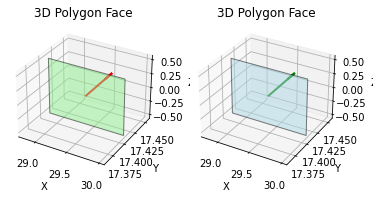

<Figure size 432x288 with 0 Axes>

In [87]:
from utils.mesh_checks import *
import warnings

indx = 1 # select face here
face_idx_vtk = ordered_vtk_idx[indx]
face_idx_of = ordered_of_idx[indx]

# Create plot
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')

face_idx_vtk = ordered_vtk_idx[indx]
face_idx_of = ordered_of_idx[indx]
n_vec_gt = torch.nn.functional.normalize(Sf_gt, dim=-1)
fig = plt.figure()
ax1 = plot_face_3d(ax1, mesh.vertices[mesh.faces[face_idx_vtk]], 
                color='lightgreen', elev=30, azim=-60, show_vertices=False)
ax1 = plot_normal_vector(ax1, 
                        mesh.face_centers[face_idx_vtk], 
                        mesh.face_normal_unit_vectors[face_idx_vtk], color='red')

ax2 = plot_face_3d(ax2, meshOfpp.points[meshOfpp.faces[face_idx_of]], 
                    color='lightblue', elev=30, azim=-60, show_vertices=False)
try:
    ax2 = plot_normal_vector(ax2, 
                            torch.mean(torch.tensor(meshOfpp.points[meshOfpp.faces[face_idx_of]]),dim=0), 
                            n_vec_gt[face_idx_of], color='green')
except Exception as e:
    print(f"Error plotting normal vector: vector is not an internal face.idx {face_idx_of}")
    warnings.warn(f"An error occurred: {e}", RuntimeWarning)

plt.tight_layout()
plt.show()

In [77]:
print(' our vector', mesh.face_normal_unit_vectors[face_idx_vtk], '\n vs\n',
      'OF vector', n_vec_gt[face_idx_of])

 our vector tensor([0., 1., 0.], dtype=torch.float64) 
 vs
 OF vector tensor([0., 1., 0.], dtype=torch.float64)


In [37]:
from utils.mesh_checks import check_quad_is_valid
for vertices in mesh.vertices[mesh.faces]:
    if check_quad_is_valid(vertices):
        pass
    else:
        print("Invalid quad found:", vertices)